In [43]:
using KnetLayers, Random, Plots, DataFrames, StatsPlots, Query, PlotThemes, CSV
import KnetLayers: IndexedDict, arrtype, nllmask
setoptim!(M, optimizer) = for p in params(M); p.opt = deepcopy(optimizer); end
gpu(0)
KnetLayers.gc()

┌ Info: Recompiling stale cache file /home/gridsan/eakyurek/.julia/compiled/v1.2/StatsPlots/SiylL.ji for StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1240


In [44]:
gr()
theme(:ggplot2)
ENV["COLUMNS"] = 500
ENV["LINES"]   = 100

100

In [5]:
vocab    = IndexedDict([collect('0':'9'); collect('a':'z')])
digits   = '0':2:'8'
chars    = 'a':'h'
holdout  = ['0' .* ('a':'b'); '2'.*('c':'d'); '4'.*('e':'f'); '8'.*('g':'h'); "6h"]
data     = [d*c for d in digits, c in chars if d*c ∉ holdout ]

31-element Array{String,1}:
 "2a"
 "4a"
 "6a"
 "8a"
 "2b"
 "4b"
 "6b"
 "8b"
 "0c"
 "4c"
 "6c"
 "8c"
 "0d"
 "4d"
 "6d"
 "8d"
 "0e"
 "2e"
 "6e"
 "8e"
 "0f"
 "2f"
 "6f"
 "8f"
 "0g"
 "2g"
 "4g"
 "6g"
 "0h"
 "2h"
 "4h"

In [6]:
𝑿 = [vocab[collect(d)] for d in data]
V = length(vocab)

36

In [7]:
# interact(e,h,W)     = softmax(sum(e .* (W * h), dims=1))
interact(e,h,W)     = softmax(e .* (W * h))
drop(x)             = dropout(x, 0.5)
function attend(e,h,W,layer) 
    α = interact(e,h,W)
    layer(sum(drop(α .* h), dims=2)), α 
end
function encode(model, xi, 𝑿╲i=nothing)
    e   = drop(vec(model.encoder(xi))) # 2H
    if isnothing(𝑿╲i)
        model.Wμ(e), model.Wσ(e), nothing
    else          
        h          = drop(mat(model.encoder(𝑿╲i))) # H x 2 x (T-1)
        μ, αμ      = attend(e,h,model.Wμa.weight,model.Wμ)
        logσ², ασ  = attend(e,h,model.Wσa.weight,model.Wσ)
        μ, logσ², (αμ=αμ,ασ=ασ)
    end 
end

function decode(model, zi, 𝑿╲i=nothing)
    if !isnothing(𝑿╲i)
        h      = mat(drop(model.encoder(𝑿╲i)))  # H x 2 x (T-1)
        zi, αz = attend(zi,h,model.Wza.weight,model.Wz)
        model.decoder(reshape(zi,size(zi,1) ÷ 2,2)), αz
    else
        model.decoder(reshape(zi,size(zi,1) ÷ 2,2)), nothing
    end
end
    

isencatt(model)    = haskey(model, :Wμa) &&  haskey(model, :Wσa) 
isdecatt(model)    = haskey(model, :Wza) 
hiddensize(model)  = size(model.encoder.weight,1)
elementtype(model) = eltype(model.encoder.weight)

elementtype (generic function with 1 method)

In [8]:
function loss(model, xi, 𝑿╲i; encatt=false, decatt=false, results=false)
    μ, logσ², αe =  encode(model, xi, (encatt ? 𝑿╲i : nothing))
    σ² = exp.(logσ²)
    σ  = sqrt.(σ²)
    z  = μ .+ randn!(similar(μ)) .* σ
    xp, αd = decode(model, z, (decatt ? 𝑿╲i : nothing))
    KL = -sum(1 .+ logσ² .- μ.^2 .- σ²)/ 2length(μ)
    L  = nll(xp,xi) + KL
    if results
        L, greedy(xp), (αe=αe, αd=αd)
    else
        L
    end
end

function eval(model, vocab, 𝑿)
    results  = Dict()
    for i=1:length(𝑿)
        xi  = 𝑿[i]
        𝑿╲i = hcat([𝑿[1:i-1]; 𝑿[i+1:end]]...)
        L, y, att = loss(model, xi,  𝑿╲i; encatt=isencatt(model), decatt=isdecatt(model), results=true)
        results[xi] = (L=L,y=y,att=att)
    end
    decres = empty(results)
    for (k,v) in results
        decres[join(vocab[k])] = (L=v.L,y=join(vocab[v.y]), att = v.att)
    end
    return decres
end

function train!(model, 𝑿; epoch=20, optim=Adam())
    setoptim!(model,optim)
    for i=1:epoch
        lss, cnt= 0.,0.
        for (i,xi) in enumerate(shuffle(𝑿))
            xi   = 𝑿[i]
            𝑿╲i = hcat([𝑿[1:i-1]; 𝑿[i+1:end] ]...)
            J = @diff loss(model, xi, 𝑿╲i, encatt=isencatt(model), decatt=isdecatt(model))
            for w in params(J)
                KnetLayers.update!(value(w), grad(J,w), w.opt)
            end            
            lss += value(J)
            cnt += 1
        end
    end
end

train! (generic function with 1 method)

In [9]:
function samplingparams(model, 𝑿; useprior=false)
    H,T   = hiddensize(model), elementtype(model)
    if useprior
        arrtype(zeros(T,2H,1)), arrtype(ones(T,2H,1))
    else
        μ, σ² = arrtype(zeros(T,2H,1)), arrtype(zeros(T,2H,1))
        for i=1:length(𝑿)
            xi  = 𝑿[i]
            𝑿╲i = hcat([𝑿[1:i-1];𝑿[i+1:end]]...)
            μi, logσ²,_ =  encode(model, xi,  isencatt(model) ? 𝑿╲i : nothing)
            μ  .+= μi
            σ² .+= exp.(logσ²)
        end
        μ/length(𝑿),  σ²/length(𝑿)
    end
end

function sample(model, vocab, 𝑿; N=100, useprior=false)
    μ, σ² =  samplingparams(model,𝑿; useprior=useprior) 
    σ  = sqrt.(σ²)
    𝑿 =  hcat(𝑿...)
    samples = []
    for i=1:N
        z     = μ .+ randn!(similar(μ)) .* σ
        xp, _ = decode(model, z, (isdecatt(model) ? 𝑿 : nothing))
        push!(samples,join(vocab[greedy(xp)]))
    end
    return samples
end

sample (generic function with 1 method)

In [10]:
# interact(e,h,W)     = softmax(sum(e .* (W * h), dims=1))
# interact_b(e,h,mask::Nothing) = softmax(e .* h, dims=(1,2))
# drop(x) = dropout(x, 0.5)
function interact(e, h; mask=nothing, sumout=false)
    y = isnothing(mask) ?  (e .* h) : ( e .* h .+ mask)
    if sumout
        α = softmax(mat(sum(y,dims=1)),dims=1)
        reshape(α,1,size(α)...)
    else
        softmax(y, dims=(1,2))
    end
end

function attend(e, h, W, layer, mask=nothing; sumout=false) 
    h3d = reshape(W*h, size(h,1),size(h,2),1)
    h   = reshape(h, size(h,1),size(h,2),1)
    α   = interact(e,h3d; mask=mask, sumout=sumout)  
    layer(mat(sum(drop(α .* h), dims=2))), α 
end

function encode(model, xi, 𝑿=nothing, mask=nothing)
    e = drop(model.encoder(xi))
    H,N,B = size(e)
    if isnothing(𝑿)
        e = reshape(e,H*N,B)
        model.Wμ(e), model.Wσ(e), nothing
    else   
        e = reshape(e,H*N,1,B)
        h  = drop(mat(model.encoder(𝑿))) # 2H x  L
        μ, αμ    = attend(e,h,model.Wμa.weight,model.Wμ, mask)
        logσ², ασ = attend(e,h,model.Wσa.weight,model.Wσ, mask)
        μ, logσ², (αμ=αμ,ασ=ασ)
    end 
end

function decode(model, zi, 𝑿=nothing, mask=nothing)
    if !isnothing(𝑿)
        h      = mat(drop(model.encoder(𝑿)))  # 2H x B
        zi     = reshape(zi,size(zi,1),1,size(zi,2))
        zi, αz = attend(zi,h,model.Wza.weight,model.Wz, mask)
        model.decoder(reshape(zi,size(zi,1) ÷ 2,2,size(zi,2))), αz
    else
        model.decoder(reshape(zi,size(zi,1) ÷ 2,2,size(zi,2))), nothing
    end
end


function loss(model, xi, 𝑿; mask=nothing, encatt=false, decatt=false, results=false)
    μ, logσ², αe =  encode(model, xi, (encatt ? 𝑿 : nothing), mask)
    σ² = exp.(logσ²)
    σ  = sqrt.(σ²)
    z  = μ .+ randn!(similar(μ)) .* σ
    xp, αd = decode(model, z, (decatt ? 𝑿 : nothing), mask)
    KL = -sum(1.0f0 .+ logσ² .- μ.^2 .- σ²) / 2length(μ)
    L  = nllmask(xp,xi) + KL
    if results
        L, greedy(xp), (αe=αe, αd=αd)
    else
        L
    end
end


function get_mask(indices,L)
    B = length(indices)
    mask = zeros(Float32,1,L,B)
    for (i,ind) in enumerate(indices)
        mask[1,ind,i] = -1.0f30
    end
    return arrtype(mask)
end
    

batches(X,B) = [collect(i:i+B-1) for i=1:B:length(X)-B+1]

    
function train!(model, 𝑿; epoch=20, optim=Adam(), B=2)
    setoptim!(model,optim)
    for i=1:epoch
        lss, cnt= 0.,0.
        X = shuffle(𝑿)
        for (i,indices) in enumerate(batches(X,B))
            xi   = hcat(X[indices]...)
            xt   = hcat(X...)
            mask = get_mask(indices,length(X))
            J = @diff loss(model, xi, xt, mask=mask, encatt=isencatt(model), decatt=isdecatt(model))
            for w in params(J)
                KnetLayers.update!(value(w), grad(J,w), w.opt)
            end            
            lss += value(J)
            cnt += 1
        end
    end
end

train! (generic function with 1 method)

In [12]:
function get_vae_models(H=256)
    encoder    = Embed(input=V,output=H)
    decoder    = Embed(input=H,output=V)
    Wμa        = Multiply(input=2H,output=2H)
    Wμ         = Dense(input=2H,output=2H, activation=ELU())
    Wza        = Multiply(input=2H,output=2H)
    Wz         = Dense(input=2H,output=2H, activation=ELU())
    Wσa        = Multiply(input=2H,output=2H)
    Wσ         = Dense(input=2H,output=2H, activation=ELU())
    model_atte = (encoder=encoder, Wμa=Wμa, Wμ=Wμ, Wσa=Wσa, Wσ=Wσ, decoder=decoder)
    model_vae  = (encoder=encoder, Wμa=Wμa, Wμ=Wμ, Wσ=Wσ, decoder=decoder)
    model_attd = (encoder=encoder, Wμ=Wμ, Wσ=Wσ, Wza=Wza, Wz=Wz, decoder=decoder)
    model_attde = (encoder=encoder, Wμa=Wμa, Wμ=Wμ, Wσa=Wσa, Wσ=Wσ, Wza=Wza, Wz=Wz, decoder=decoder)
    (model_vae, model_atte, model_attd, model_attde);
end

get_vae_models (generic function with 2 methods)

In [13]:
function samplingparams(model, 𝑿; useprior=false, B=2)
    H,T   = hiddensize(model), elementtype(model)
    if useprior
        arrtype(zeros(T,2H,1)), arrtype(ones(T,2H,1))
    else
        μ, σ² = arrtype(zeros(T,2H,1)), arrtype(zeros(T,2H,1))
        for (i,indices) in enumerate(batches(𝑿,B))
            xi   = hcat(𝑿[indices]...)
            xt   = hcat(𝑿...)
            mask = get_mask(indices,length(𝑿))
            μi, logσ²,_ =  encode(model, xi,  isencatt(model) ? xt : nothing, mask)
            μ  .+= sum(μi,dims=2)
            σ² .+= sum(exp.(logσ²),dims=2)
        end
        μ/length(𝑿),  σ²/length(𝑿)
    end
end

greedy(y) = mapslices(argmax, y, dims=1)
function sample(model, vocab, 𝑿; N=100, useprior=false)
    μ, σ² =  samplingparams(model,𝑿; useprior=useprior) 
    xt    =  hcat(𝑿...)
    r     =  similar(μ,size(μ,1),N)
    z     =  μ .+ randn!(r) .* sqrt.(σ²)
    xp, _ =  decode(model, z, (isdecatt(model) ? xt : nothing),  nothing)
    vec(mapslices(x->join(vocab[greedy(x)]), convert(Array, xp), dims=(1,2)))
end

sample (generic function with 1 method)

In [14]:
cmodel = get_vae_models(256)[2]
train!(cmodel, 𝑿; epoch=30, optim=Adam(),B=2)
sampled = sample(cmodel, vocab, 𝑿; N=100)
unseen = [s for s in sampled if s ∈ holdout]
wrong  = [s for s in sampled if s ∉ [data;holdout]]   
unique(unseen)
# push!(df2, (isencatt(cmodel), isdecatt(cmodel), H, opt.lr, "$opt", epoch,  length(unseen), length(holdout)-length(unique(unseen)), length(wrong),length(unique(unseen)) ))
# print((row+=1), " ")

7-element Array{String,1}:
 "0a"
 "8g"
 "6h"
 "0b"
 "2d"
 "4e"
 "4f"

In [11]:
sampled = sample(cmodel, vocab, 𝑿; N=100, useprior=true)
unseen = [s for s in sampled if s ∈ holdout]
wrong  = [s for s in sampled if s ∉ [data;holdout]]   
unique(unseen)

UndefVarError: UndefVarError: cmodel not defined

In [12]:
plot(Array(μ))

UndefVarError: UndefVarError: μ not defined

In [13]:
function probmap(y)
    u=unique(y)
    Dict([(i,count(x->x==i,y) / length(y)) for i in u])
end

probmap (generic function with 1 method)

In [153]:
df2 = DataFrame(EncoderAtt = Bool[], DecoderAtt = Bool[], B=Int[], H = Int[], lr=Float64[], Optimizer = String[], Epoch = Int[], UnseenCnt=Int[], MissedClass=Int[], WrongCount=Int[])

,EncoderAtt,DecoderAtt,B,H,lr,Optimizer,Epoch,UnseenCnt,MissedClass,WrongCount
,Bool,Bool,Int64,Int64,Float64,String,Int64,Int64,Int64,Int64


In [ ]:
row = 0
for H in (256,128)
    for opt in (Adam, Rmsprop, SGD)
        for lr in (0.001, 0.01, 0.1, 1.0)
            for B in (1,2,4,8,16)
                for epoch in (10,20,30)
                    for model in get_vae_models(H)
                        cmodel = deepcopy(model)
                        train!(cmodel, 𝑿; epoch=epoch, optim=opt(lr=lr))
                        sampled = sample(cmodel, vocab, 𝑿; N=100)
                        unseen = [s for s in sampled if s ∈ holdout]
                        wrong  = [s for s in sampled if s ∉ [data;holdout]]              
                        push!(df2, (isencatt(cmodel), isdecatt(cmodel), B, H, lr, "$opt", epoch,  length(unseen), length(holdout)-length(unique(unseen)), length(wrong)))
                        print((row+=1), " ")
                    end
                end
           end
        end
    end
end
df2[!,:UnseenClass] = length(holdout) .- df2.MissedClass;

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 

In [17]:
df2[!,:UnseenClass] = length(holdout) .- df2.MissedClass;

In [157]:
df3 = df2 |> @orderby_descending(_.UnseenClass) |> @thenby(_.WrongCount) |> DataFrame

,EncoderAtt,DecoderAtt,B,H,lr,Optimizer,Epoch,UnseenCnt,MissedClass,WrongCount,UnseenClass
,Bool,Bool,Int64,Int64,Float64,String,Int64,Int64,Int64,Int64,Int64
1,0,0,4,256,0.001,Rmsprop,20,23,0,0,9
2,1,0,1,256,0.01,Rmsprop,20,21,0,0,9
3,1,0,4,256,0.01,Rmsprop,10,27,0,0,9
4,1,0,2,128,0.01,Rmsprop,10,20,0,0,9
5,1,0,16,128,0.01,Rmsprop,30,26,0,0,9
6,1,0,2,128,0.1,SGD,20,18,0,0,9
7,0,0,8,256,0.001,Adam,10,23,0,1,9
8,1,0,2,256,0.01,Adam,30,20,0,1,9
9,1,0,4,256,0.01,Adam,20,23,0,1,9


In [166]:
cmodel = get_vae_models(128)[2]
train!(cmodel, 𝑿; epoch=60, optim=Adam())
sampled = sample(cmodel, vocab, 𝑿; N=100)
unseen = [s for s in sampled if s ∈ holdout]
wrong  = [s for s in sampled if s ∉ [data;holdout]]
result = eval(cmodel, vocab, 𝑿)

┌ Info: Building the CUDAnative run-time library for your sm_70 device, this might take a while...
└ @ CUDAnative /home/gridsan/eakyurek/.julia/packages/CUDAnative/Lr0yj/src/compiler/rtlib.jl:173


BoundsError: BoundsError: attempt to access (128, 2)
  at index [3]

In [148]:
unique(unseen)

6-element Array{String,1}:
 "8g"
 "4e"
 "4f"
 "2d"
 "0b"
 "2c"

In [150]:
for (k,v) in result
    if k==v.y
        println(v)
    end
end

(L = 0.92936647f0, y = "6d", att = (αe = (αμ = K32(256,30)[1.9662112e-7⋯], ασ = K32(256,30)[4.431309e-7⋯]), αd = nothing))
(L = 0.8953346f0, y = "4c", att = (αe = (αμ = K32(256,30)[1.828638e-5⋯], ασ = K32(256,30)[4.588832e-5⋯]), αd = nothing))


In [152]:
inp = "4h"
v = result[inp]
StatsPlots.bar(v.y, sum(v.att.αe.αμ, dims=1), xticks=(0.5:1:length(v[2])-0.5, v[2]), title="$inp->$(v[1])", size=(1200,300))

ErrorException: Cannot convert String to series data for plotting

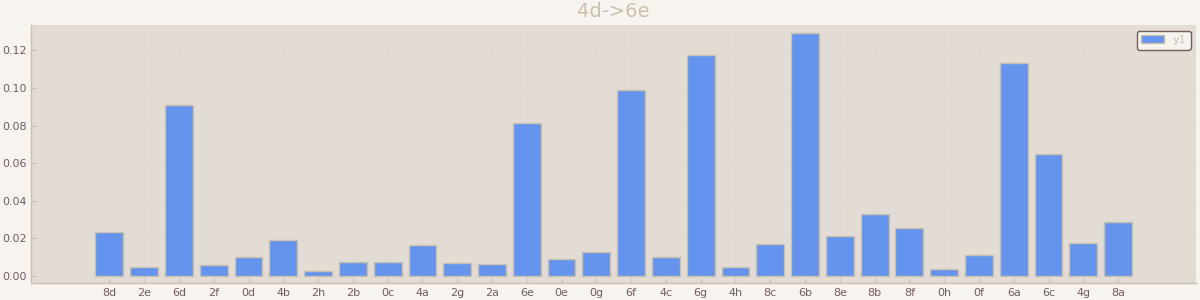

In [41]:
inp = "4d"
v = d[inp]
StatsPlots.bar(1:length(v[4]), v[3], xticks=(1:length(v[2]), v[2]), title="$inp->$(v[1])", size=(1200,300))

In [ ]:
df2 |> @orderby_descending(_.UnseenClass) |> @thenby(_.WrongCount) |> DataFrame

In [ ]:
bestmodels = df2 |>  @filter(_.Epoch==20 && _.Optimizer == "Rmsprop" && _.lr==0.001) |> DataFrame
@df bestmodels groupedbar(:H, :UnseenClass , group = {Enc_Att = :EncoderAtt, Dec_Att  = :DecoderAtt}, xlabel = "Models", ylabel = "# of Unseen Classes", title = "# of Unseen Classes vs Epoch on Different Models")

In [ ]:
bestmodels = df2 |>  @filter(_.Epoch==20 && _.Optimizer == "Rmsprop" && _.lr==0.001) |> DataFrame
@df bestmodels groupedbar(:H, :WrongCount , group = {Enc_Att = :EncoderAtt, Dec_Att  = :DecoderAtt}, xlabel = "Models", ylabel = "# of Unseen Classes", title = "# of Unseen Classes vs Epoch on Different Models")

In [ ]:
E = 64
H = 256

In [ ]:
lmmodel = (rnn=LSTM(input=V,hidden=H,embed=E,dropout=0.5), output=Linear(input=H,output=V))

In [ ]:
train!(lmmodel,x_onehot; optim=Adam(lr=0.01))

In [ ]:
loss(lmmodel,x_onehot[1])

In [ ]:
sampled =[vocab[predict(lmmodel,2)] for i=1:100];

In [ ]:
unseen = [join(s) for s in sampled if join(s) ∈ holdout]
wrong  = [join(s) for s in sampled if join(s) ∉ [data;holdout]]
dkl = KLDivergence(data,holdout,sampled)               

In [ ]:
unseen

# Morph Data

In [88]:
using KnetLayers, Plots
import KnetLayers: nllmask, arrtype
setoptim!(M, optimizer) = for p in params(M); p.opt = deepcopy(optimizer); end
theme(:default)
gpu(0)
KnetLayers.gc()
include("parser.jl")
download(SIGDataSet)
ENV["LINES"]   = 50

50

In [125]:
data  = map(parseDataLine, eachline("./data/Sigmorphon/task1/all/turkish-train-high"));
vocab = Vocabulary(data)
edata = encode(data,vocab);
test  = map(parseDataLine, eachline("./data/Sigmorphon/task1/all/turkish-test"));
tdata = encode(test,vocab);

In [126]:
vocab.chars

IndexedDict{Char}(Dict('ç' => 31,'w' => 45,'Z' => 58,'o' => 5,'B' => 46,'h' => 15,'i' => 11,'r' => 12,'ğ' => 29,'P' => 60…), ['❓', '⭕', '🏁', '🎬', 'o', 't', 'u', 'z', ' ', 'b'  …  'î', 'V', 'K', 'İ', 'G', 'C', 'Ç', 'Z', 'W', 'P'])

In [127]:
trainsfs = unique(map(x->join(x.surface),data))
testsfs =  unique(map(x->join(x.surface),test)) 

997-element Array{String,1}:
 "peynirli pastalarınızı"             
 "bisküvilerinizde"                   
 "önlerine"                           
 "sosluğunun"                         
 "sürtüklerinde"                      
 "muzlarımıza"                        
 "seçmenlerinde"                      
 "düldüllerimi"                       
 "güdüme"                             
 "işkenceciliklerinden"               
 "zibidilerinden"                     
 "ritimlerinizde"                     
 "kömlerimden"                        
 "kasidelermiş"                       
 "davranışlarınıza"                   
 "intikamım"                          
 "düşünceliyiz"                       
 "saydırıyor"                         
 "konularınızın"                      
 "oyunculardık"                       
 "şikâyet eder mi?"                   
 "ağlar mısınız?"                     
 "gizlemedi mi?"                      
 ⋮                                    
 "yıpranıyor musun?"               

In [128]:
vocab.specialIndices

(unk = 1, mask = 2, eow = 3, bow = 4)

In [129]:
drop(x) = dropout(x, 0.3)
function interact(e, h; sumout=false)
    y = e .* h
    if sumout
        α = softmax(mat(sum(y,dims=1)),dims=1)
        reshape(α,1,size(α)...)
    else
        softmax(y, dims=(1,2))
    end
end

function attend(ea,  h, W, layer; sumout=false) 
    α   = interact(ea,W(h); sumout=sumout)  
    layer(mat(sum(drop(α .* h), dims=2))), α 
end
function encode(morph, xi, xt) 
    e     = morph.encoder(xi.tokens; batchSizes=xi.batchSizes, hy=true).hidden
    H,B,_ = size(e)
    h     = reshape(cat1d((morph.encoder(ex.tokens; batchSizes=ex.batchSizes, hy=true).hidden for ex  in xt)...), H, 2morph.num, B)
    μ, αu = attend(reshape(morph.Weaμ(e),H,1,B), h, morph.Wμa, morph.Wμ; sumout=false) 
    logσ², ασ = attend(reshape(morph.Weaσ(e),H,1,B), h, morph.Wσa,  morph.Wσ; sumout=false)    
    return μ, logσ², (αu=αu,ασ=ασ)
end

function decode(morph, z, xi=nothing; bow=4, maxL=20)
    if isnothing(xi)
         B      = size(z,2)
         H      = hiddensize(morph)
         input  = fill!(Vector{Int}(undef,B),bow)
         #y      = morph.decoder(input;batchSizes=[B]).y
         preds  = zeros(Int,B,maxL)
         h,c = z, zero.(z)
         for i=1:maxL
            out      = morph.decoder(input,h,c;batchSizes=[B], hy=true, cy=true)
            h,c = out.hidden, out.memory          
            input  = vec(mapslices(x->catsample(softmax(x)), convert(Array,morph.output(out.y)), dims=1))
            preds[:,i] = input
         end
        return preds
    else
        x = pad_packed_sequence(xi, bow, toend=false)
        y = morph.decoder(x.tokens, reshape(z,size(z)...,1); batchSizes=x.batchSizes).y
        morph.output(y)
    end
end

function loss(morph, vocab, xi, x; λ=0.0)
    μ, logσ², _ =  encode(morph, xi,x)
    σ² = exp.(logσ²)
    σ  = sqrt.(σ²)
    z  = μ .+ randn!(similar(μ)) .* σ
    y  = decode(morph, z, xi; bow=vocab.specialIndices.bow)
    KL = -sum(1.0f0 .+ logσ² .- μ.^2 .- σ²) / 2length(μ)
    yt  = pad_packed_sequence(xi, vocab.specialIndices.eow)
    L  = KnetLayers.nllmask(y,yt.tokens) + λ * KL
end

function attentions(model, data, vocab;  B=16)
    edata = Iterators.Stateful(data)
    attentions = []
    while ((d = getbatch(edata,B)) !== nothing)
        xi,xt = d
        μ,logσ²,αs = encode(model, xi, xt)
        sfs = map(inds -> xi.tokens[inds],_batchSizes2indices(xi.batchSizes))
        exs = [map(inds -> x.tokens[inds],_batchSizes2indices(x.batchSizes)) for x in xt]
        push!(attentions, (sfs,exs,map(Array,αs)))
    end
    return attentions
end

function train!(model, data, vocab; epoch=20, optim=Adam(), B=16, λrate = 1/1000 )
    setoptim!(model,optim)
    λ = 1.0
    for i=1:epoch
        lss = 0.0
        cnt = 0
        edata = Iterators.Stateful(data)
        while ((d = getbatch(edata,B)) !== nothing)
            J = @diff loss(model ,vocab, d...;λ=λ)
            lss += value(J)
            cnt += 1
            for w in params(J)
                KnetLayers.update!(value(w), grad(J,w), w.opt)
            end
        end
        println(lss/cnt)
    end
end

hiddensize(model)  = encoder.specs.hiddenSize
elementtype(model) = eltype(model.encoder.params)

function samplingparams(model, data; useprior=false, B=16)
    H,T   = hiddensize(model), elementtype(model)
    if useprior
        arrtype(zeros(T,H,1)), arrtype(ones(T,H,1))
    else
        μ, σ² = arrtype(zeros(T,H,1)), arrtype(zeros(T,H,1))
        cnt = 0
        edata = Iterators.Stateful(data)
        while ((d = getbatch(edata,B)) !== nothing)
            μi, logσ² = encode(model, d...)
            μ  .+= sum(μi,dims=2)
            σ² .+= sum(exp.(logσ²),dims=2)
            cnt += 1
        end
        μ/cnt, σ²/cnt
    end
end

greedy(y) = mapslices(argmax, y, dims=1)
function trim(chars::Vector{Int},vocab)
    out = Int[]
    for c in chars
        c == vocab.specialIndices.eow && break
        if c ∉ vocab.specialIndices
            push!(out,c)
        end
    end
    return join(vocab.chars[out])
    end 

function sample(model, vocab, data; N=5, useprior=false)
    μ, σ² =  samplingparams(model, data; useprior=useprior) 
    samples = []
    for i = 1 : (N ÷ 5) +1
        r     =  similar(μ,size(μ,1),5)
        z     =  μ .+ randn!(r) .* sqrt.(σ²)
        y     = decode(model, z)
        s     = mapslices(x->trim(x,vocab),y, dims=2)
        push!(samples,s)
    end
    cat1d(samples...)
end

function catsample(p)
    r = rand()
    for c = 1:length(p)
        r -= p[c]
        r < 0 && return c
    end
    
end

catsample (generic function with 1 method)

In [130]:
H=512
E=128
V=length(vocab.chars)
encoder = LSTM(input=V,hidden=H,embed=E,dropout=0.3)
decoder = LSTM(input=V,hidden=H,embed=E,dropout=0.3)
decoder.embedding = encoder.embedding
morph = (encoder=encoder,
         Wμ=MLP(H,H,H, activation=Tanh()), 
         Wσ=MLP(H,H,H, activation=Tanh()), 
         Weaμ=Multiply(input=H, output=H),
         Weaσ=Multiply(input=H, output=H),
         Wμa=Multiply(input=H, output=H), 
         Wσa=Multiply(input=H, output=H),
         output=Linear(input=H,output=V), 
         decoder = decoder, 
         num=edata.num)
train!(morph, edata, vocab; optim=Adam(), epoch=20)

2.141355983172392
1.6838976055029198
1.5369581817435216
1.399686452679371
1.2662317121724946
1.1589578542788164
1.081144680024404
1.023404108497675
0.9785395750623196
0.9412301780572976
0.9100752263428294
0.8822844433415914
0.8590174745313416
0.839049188545224
0.8245330856163171
0.8121851910341066
0.8024047108154395
0.794093208051502
0.7861300886907382
0.7776877627885842


In [131]:
samples = unique(sample(morph, vocab, edata; N=10000, useprior=true))

7077-element Array{String,1}:
 "önlerimizi"          
 "aktörler"            
 "üvümlerinin"         
 "pirinlerden"         
 "evciklerimize"       
 "büyük babalarda"     
 "şort"                
 "damlamadılar mı?"    
 "havadam"             
 "kovulmuyorlar"       
 "bakmam"              
 "pırasam"             
 "sürününüz"           
 "tanıdılar"           
 "taneleri"            
 "üvey oğularını"      
 "yönetim mi?"         
 "sonbaya"             
 "totemciymişsin"      
 "otocularımız"        
 "seçmelerinin"        
 "erneğinizden"        
 "medrese"             
 ⋮                     
 "framlarınızı"        
 "maşalarımız"         
 "giyzimizi"           
 "saksahanımızı"       
 "kılkapalarınızı"     
 "kolaylı htekralarını"
 "hediyi"              
 "aksanlarınız"        
 "üreticiliklerini"    
 "erimiyor muyuz?"     
 "küzbüğünüzün"        
 "kasmıyorsun"         
 "eksenlerimi"         
 "kovdiriyor"          
 "medresmeyecekler"    
 "bilyelerdim"         
 "ihemleri

In [134]:
samples[findall([s ∈ trainsfs for s in samples])]

1620-element Array{String,1}:
 "aktörler"         
 "büyük babalarda"  
 "damlamadılar mı?" 
 "pırasam"          
 "tanıdılar"        
 "taneleri"         
 "totemciymişsin"   
 "seçmelerinin"     
 "şarklarımdan"     
 "çöpü"             
 "yaratmalarına"    
 "yardımcılığının"  
 "aldırmadınız mı?" 
 "birleştirtmiyordu"
 "sözlüğümüzün"     
 "milimetrende"     
 "bıkıyor muyduk?"  
 "itlerdik"         
 "ilerletmezler"    
 "totemcilerinden"  
 "yardımcılıktınız" 
 "dış ağların"      
 "anasızlığımın"    
 ⋮                  
 "meşelerimizi"     
 "seccadeleriniz"   
 "peçetelerimde"    
 "sürüdüler"        
 "arkadaşlıklarımız"
 "sevenleriniz"     
 "yongamızın"       
 "yaratmaya"        
 "abajurcusunuz"    
 "eziyetçiler"      
 "ongununun"        
 "iğrenir"          
 "adalenizde"       
 "mevkilerinizde"   
 "yaymıyor muydum?" 
 "islerinizi"       
 "ayakkabılarında"  
 "ürününde"         
 "ettiriyorlar"     
 "savaşçınız"       
 "soygazımızdan"    
 "kasmıyorsun"      

In [135]:
samples[findall([s ∈ testsfs for s in samples])]

11-element Array{String,1}:
 "dalgıcımdan"  
 "leşler"       
 "dışlarında"   
 "yüzeyler"     
 "beyitler"     
 "nedenlerim"   
 "saldırıyorlar"
 "şehrimde"     
 "götlerinde"   
 "omletinizde"  
 "yıpranmaz mı?"

In [136]:
samples2 = unique(sample(morph, vocab, edata; N=10000, useprior=false))

8413-element Array{String,1}:
 "vazoların"           
 "netleri"             
 "izdiniz"             
 "petlerimizi"         
 "kısbatanlarınızda"   
 "kullanmamayacağız"   
 "çedimiz"             
 "manınızı"            
 "gündöndümüz"         
 "sezmiyordular"       
 "eksenlerimin"        
 "yitmeyeceksin"       
 "eşiğimizin"          
 "sivilcerin"          
 "onutunuz"            
 "öklerinde"           
 "bilginizde"          
 "ncim"                
 "heterosem"           
 " şeyketler"          
 "imlerinin"           
 "eğimiyorsunuz"       
 "taşılarımda"         
 ⋮                     
 "çermedin"            
 "kursiyerden"         
 "sebpilerinize"       
 "ombudsmunuz"         
 "işeğin"              
 "patiler"             
 "ayımlarında"         
 "düzmüyor muyuz?"     
 "papağamıza"          
 "bezmiyor muyduk?"    
 "yalamıyordunuz"      
 "ilimlerimizden"      
 "cümbeli değil miydim"
 "solucamda"           
 "engisim"             
 "teniler"             
 "interdil

In [137]:
samples2[findall([s ∈ trainsfs for s in samples2])]

1091-element Array{String,1}:
 "netleri"             
 "gündöndümüz"         
 "sezmiyordular"       
 "eksenlerimin"        
 "yitmeyeceksin"       
 "kovdurtmuyor"        
 "totemciymişsin"      
 "namazlarından"       
 "yaratıydı"           
 "yüksüklerinde"       
 "sesçilerinde"        
 "ebediyetimi"         
 "sınıyorlar mıydı?"   
 "derileriniz"         
 "çöküyorsunuz"        
 "kaydedicime"         
 "ovmuyor musunuz?"    
 "umutlu değil miydin?"
 "asmadın mı?"         
 "inanmıyordu"         
 "çökertik mi?"        
 "süzmediniz mi?"      
 "öküz"                
 ⋮                     
 "meşelerimizde"       
 "olmazsa olmazların"  
 "dadılarmışız"        
 "kovdurmadılar"       
 "yazanağına"          
 "haçının"             
 "biliriz"             
 "eşcinselin"          
 "öğrenirim"           
 "Türkçeleştirirsiniz" 
 "bohça"               
 "milyonerdi"          
 "cimcimem"            
 "sineklikleri"        
 "sucuklarım"          
 "biplerinde"          
 "örneğini

In [138]:
samples2[findall([s ∈ testsfs for s in samples2])]

14-element Array{String,1}:
 "beyitler"      
 "sesteşimde"    
 "odacılarına"   
 "barışın"       
 "kelimeymişiz"  
 "sinagoglarının"
 "leşler"        
 "manalarımızı"  
 "laçoları"      
 "hocaydın"      
 "nedenlerim"    
 "jelatinleri"   
 "mumya"         
 "yıktı mı?"     

In [139]:
atts = attentions(morph,edata, vocab);

In [140]:
getsingle(sfs,exs,αs,i) = join(vocab.chars[sfs[i]]), map(e->join(vocab.chars[e]),exs[i]), map(x->x[:,:,i],αs)

getsingle (generic function with 1 method)

In [141]:
import Plots.px
theme(:default)

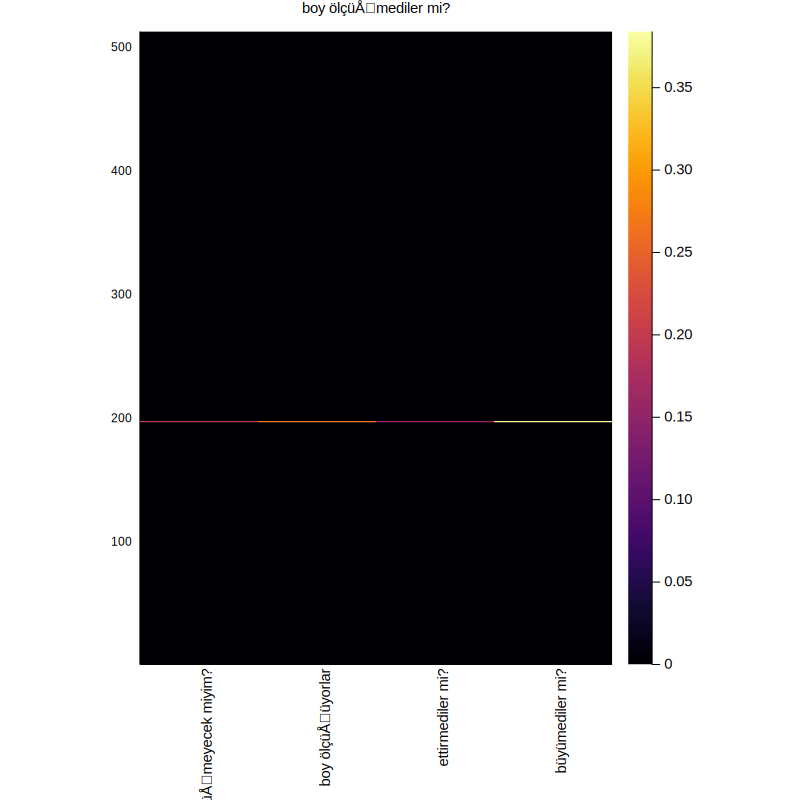

In [160]:
i = rand(1:length(atts))
s1,e1,α1 =  getsingle(atts[i]...,rand(1:16))
xs = e1
ys = 1:512
z = α1.αu
heatmap(xs, ys, z;size=(800,800), title=s1, xrotation = 90, xtickfontsize=10, titlefontsize=10, left_margin=100px, bottom_margin=100px, right_margin=100px)

In [143]:
z

2048-element Array{Float32,1}:
 3.1350786e-34 
 2.876956e-36  
 4.920323e-35  
 7.2729494e-36 
 5.3998376e-35 
 1.2648377e-35 
 4.9648875e-35 
 2.4166774e-36 
 4.882996e-35  
 2.1688486e-35 
 5.2026376e-35 
 4.3759436e-35 
 1.3930046e-33 
 2.4902808e-35 
 3.8360924e-35 
 4.8230964e-35 
 4.6880064e-35 
 9.862476e-35  
 4.841419e-35  
 2.1598095e-34 
 2.568566e-35  
 7.837779e-35  
 5.1322175e-35 
 ⋮             
 4.4480138e-35 
 8.460959e-34  
 3.5016576e-35 
 4.671376e-35  
 3.406821e-35  
 1.05059485e-35
 3.087798e-32  
 4.9464383e-35 
 3.568394e-35  
 2.738297e-35  
 5.415824e-35  
 5.25815e-35   
 4.896598e-35  
 5.4381227e-35 
 5.0584145e-35 
 5.08572e-35   
 8.4912617e-38 
 5.7645485e-35 
 4.4357756e-35 
 5.21484e-35   
 1.2644246e-34 
 5.684328e-35  